# NBA Free Throw Shooting Percentage

In this script I will aim to analyze the free-throw shooting percentage of NBA players in each period of the game.

Questions:
 - Does it go down as the game approaches the ending due to higher pressure?
 - Does it go up thanks to players being warmer, or alternatively - better shooters take the ball?

The following analysis uses NBA free-throw data between 2006 and 2016.
The data set includes information when the free throw was taken during the game, who took the shot and if it went in or not.

The data was scraped from ESPN.com. One example site is: http://www.espn.com/nba/playbyplay?gameId=261229030


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from subprocess import check_output
plt.style.use('fivethirtyeight')
%matplotlib inline



df = pd.read_csv("free_throws.csv")

In [8]:
df.head()

,end_result,game,game_id,period,play,player,playoffs,score,season,shot_made,time
0,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,0 - 1,2006 - 2007,1,11:45
1,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,0 - 2,2006 - 2007,1,11:45
2,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,18 - 12,2006 - 2007,1,7:26
3,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum misses free throw 2 of 2,Andrew Bynum,regular,18 - 12,2006 - 2007,0,7:26
4,106 - 114,PHX - LAL,261031013.0,1.0,Shawn Marion makes free throw 1 of 1,Shawn Marion,regular,21 - 12,2006 - 2007,1,7:18


In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618019 entries, 0 to 618018
Data columns (total 11 columns):
end_result    618019 non-null object
game          618019 non-null object
game_id       618019 non-null float64
period        618019 non-null float64
play          618019 non-null object
player        618019 non-null object
playoffs      618019 non-null object
score         618019 non-null object
season        618019 non-null object
shot_made     618019 non-null int64
time          618019 non-null object
dtypes: float64(2), int64(1), object(8)
memory usage: 33.0+ MB


Let's create some new features - number of seconds and minutes from the beginning of the match:

In [2]:
df['minute'] = df.time.apply(lambda x: int(x[:len(x)-3]))
df['sec'] = df.time.apply(lambda x: int(x[len(x)-2:]))
df['abs_min'] = 12 - df['minute']+12*(df.period -1)
df['abs_time'] = 60*(df.abs_min-1) + 60 - df['sec']

In [3]:
def group_values(df,minute):
    made = len(df[(df.abs_min == minute) & (df.shot_made == 1)])
    total = len(df[df.abs_min == minute])
    return np.true_divide(made,total)

minutes = range(int(max(df.abs_min)))

per_min = []
for minu in minutes:
    per_min.append(group_values(df,minu))

c:\users\syson\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Now Let's plot the shooting percentage over time:

Text(0, 0.5, 'Free Throws %')

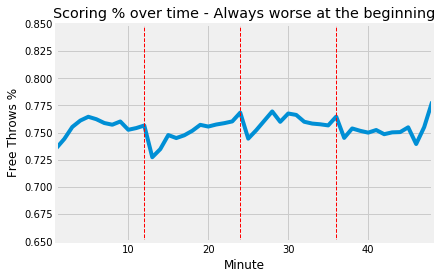

In [4]:
plt.plot(minutes,per_min)
plt.title('Scoring % over time - Always worse at the beginning')
plt.xlim([1,48])
plt.ylim([0.65,0.85])
plt.plot([12,12],[0,1], '--', linewidth = 1, color = 'r')
plt.plot([24,24],[0,1], '--', linewidth = 1, color = 'r')
plt.plot([36,36],[0,1], '--', linewidth = 1, color = 'r')
plt.plot([48,48],[0,1], '--', linewidth = 1, color = 'r')
plt.xlabel('Minute')
plt.ylabel('Free Throws %')

Interestingly, while the curve is relatively flat, 2 trends can be observed:

 1. At the beginning of every querter - the percentage drops
 2. At the end of a quarter, and by far most clearly seen at the end of the game, the shooting percentage goes up

It is possible that the number of shots also varies over time, and therefore the statistics can get less/more noisy, let's explore this:

In [ ]:
minutes_df = pd.DataFrame()
minutes_df['minutes'] = range(int(max(df.abs_min)))
minutes_df['shots'] = minutes_df.minutes.apply(lambda x: len(df[df.abs_min == x]))
minutes_df['players_num'] = minutes_df.minutes.apply(lambda x: len(np.unique(df.player[df.abs_min == x])))

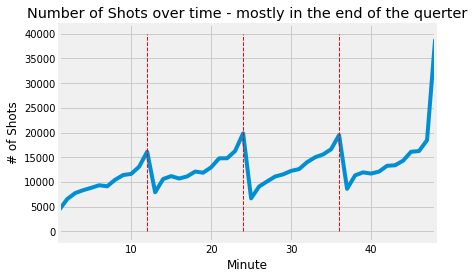

In [ ]:
plt.plot(minutes_df['shots'])
plt.title('Number of Shots over time - mostly in the end of the querter')
plt.ylabel('# of Shots')
plt.xlabel('Minute')
plt.xlim([1,48])
plt.plot([12,12],[0,40000], '--', linewidth = 1, color = 'r')
plt.plot([24,24],[0,40000], '--', linewidth = 1, color = 'r')
plt.plot([36,36],[0,40000], '--', linewidth = 1, color = 'r')
plt.plot([48,48],[0,40000], '--', linewidth = 1, color = 'r')

We can see that every quarter the number of shots goes up as the quarter advances. again the last quarter is an anomaly - where the number of shots goes up significantly.

This makes sense taking into account that after a certain limit of fouls per quarter, the attacker goes to the line after every foul.

However - While we would expect the statistics of shots approaching the end of the quarter to be more consistent thanks to the larger number of samples, this does not explain the consistent difference between FT% at the beginning and the end of each quarter.

In [ ]:
players_df = pd.DataFrame()
players_df['name'] = np.unique(df.player)
players_df['pct'] = players_df.name.apply(lambda x: np.true_divide(len(df[(df.shot_made == 1) & (df.player ==x)]), len(df[df.player == x])))
df['player_pct'] = df.player.apply(lambda x: players_df.pct[players_df.name == x].values[0])
minutes_df['avg_pct'] = minutes_df.minutes.apply(lambda x: np.mean(df.player_pct[df.abs_min == x]))

Another possibility is that better FT shooters take the ball more often as the end of the quarter approaches and the offense is more likely to go to the line. let's explore which players shoot when:

In [ ]:
plt.plot(minutes_df.avg_pct)
plt.xlim([2,48])
plt.ylim([0.65,0.85])
plt.plot([12,12],[0,1], '--', linewidth = 1, color = 'r')
plt.plot([24,24],[0,1], '--', linewidth = 1, color = 'r')
plt.plot([36,36],[0,1], '--', linewidth = 1, color = 'r')
plt.plot([48,48],[0,1], '--', linewidth = 1, color = 'r')
plt.xlabel('Minute')
plt.ylabel('Average FT% of players shooting')
plt.title('In the money time - the better shooters go to the line')

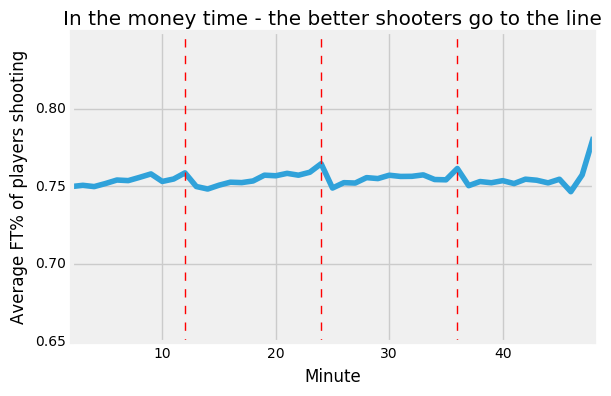

In [6]:
from IPython.display import Image
Image("go_to_line.png")

We can see in the graph above that indeed better shooters go to the line in the end of the quarter and especially in the last minute of the game. 

We also see that the phenomenon of worse shooting percentage at the beginning of the game is dminished (though not sure if totally disappears). This implies that while the rising FT% at the end of the quarter probably results from a change in the shooters "demographics" (better shooters take the ball), the phenomenon of low FT% at the beginning is less player dependent, and therefore more time dependent (physical\psychological warm up).

This can be concluded if we check how the FT% of the player improves (or not) after the first 2-3 shots, on which I am working now :)